In [3]:
from Bio import SeqIO
import pandas as pd

import torch
import os
import math
from rinalmo.pretrained import get_pretrained_model
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import numpy as np
DEVICE = "cuda:0"
print("CUDA available:", torch.cuda.is_available())
np.random.seed(42)

CUDA available: True


In [2]:
fasta_path = "rfam.fasta"
rows = []
for record in SeqIO.parse(fasta_path, "fasta"):
    header_parts = record.description.split(maxsplit=1)

    sequence_id = header_parts[0]
    description = header_parts[1] if len(header_parts) > 1 else ""

    rows.append({
        "sequence_id": sequence_id,
        "description": description,
        "sequence": str(record.seq)
    }) #this part for reading the fasta file
fasta_df = pd.DataFrame(rows) #make it pd dataframe
print(fasta_df.head())
print(fasta_df.shape)
rows = [] #not used anymore

             sequence_id                                        description  \
0   URS0000000008_559295             Lachancea thermotolerans CBS 6340 tRNA   
1   URS0000000011_637905  Shewanella violacea DSS12 Bacterial large subu...   
2  URS000000002F_1076872              Torulaspora delbrueckii CBS 1146 tRNA   
3  URS000000002F_2792677                      Torulaspora sp. CBS 2947 tRNA   
4    URS000000002F_42260                      Zygosaccharomyces mrakii tRNA   

                                            sequence  
0  ATATCCTTAATTTAATGGGTAAAATATTAGAATACGGATCTAATTA...  
1  GGTTAAGTGACTAAGCGTATACGGTGGATGCCTTGGCAGTCAGAGG...  
2  GGTACTCTGGCCGAGTGGTTTAAGGCGCCAGGTCGAGGTCCTGGTC...  
3  GGTACTCTGGCCGAGTGGTTTAAGGCGCCAGGTCGAGGTCCTGGTC...  
4  GGTACTCTGGCCGAGTGGTTTAAGGCGCCAGGTCGAGGTCCTGGTC...  
(7818286, 3)


In [3]:
fasta_df["length"] = fasta_df["sequence"].str.len() #add length column
fasta_df = fasta_df[
    (fasta_df["length"] >= 300) &
    (fasta_df["length"] <= 1000)
] #filter according to the first meeting
print(fasta_df.shape)

(175547, 4)


In [5]:
rfam_df = pd.read_csv(
    "rfam_annotations.tsv",
    sep="\t",
    header=None
) #no header annotations from rna central for rfam
rfam_df.columns = [
    "sequence_id", "rfam_id", "bit_score", "evalue",
    "seq_start", "seq_end", "rfam_start", "rfam_end",
    "description"
] #this comes from the readme file on rna central

In [2]:
#get the model this is directly from rinalmo github
model, alphabet = get_pretrained_model(model_name="giga-v1")
model = model.to(device=DEVICE)
model.eval() 

In [46]:
seqs = fasta_df["sequence"].tolist() # get the sequences to a list to feed as input to model

In [52]:
output_dir = "representations_rfam_first_token" #results directory
os.makedirs(output_dir, exist_ok=True) #create the directory
NUM_SPLITS = 200 #there will be 200 seperate files (I had only 16 GB Ram 4 gb VRAM for RTX 3070 GPU)
total_seqs = len(seqs) 
seqs_per_split = math.ceil(total_seqs / NUM_SPLITS) #amount of sequences in each file
BATCH_SIZE = 8

# initial variables and trackers for the loop
current_split_list = [] 
split_count = 0
processed_in_current_split = 0

for i in range(0, total_seqs, BATCH_SIZE):
    batch_seqs = seqs[i : i + BATCH_SIZE] #current sequences
    batch_tokens = torch.tensor(alphabet.batch_tokenize(batch_seqs), dtype=torch.int64, device=DEVICE) #convert to tokens and move to gpu 
    #the upper part is from the github of rinalmo
    
    with torch.no_grad(), torch.cuda.amp.autocast(): 
        outputs = model(batch_tokens) #from the rinalmo gets the representations withour calculating gradients
        repr_chunk = outputs["representation"].cpu() # Extracts the raw embeddings from the model output and moves them from GPU to CPU RAM.

        #Below just in case [Batch, Length, Dim] or [Length, Batch, Dim] accounted although I tried the model and kinda know 
        # the output I wanted to be sure during batches.
        if repr_chunk.shape[0] == len(batch_seqs):
            for j in range(repr_chunk.shape[0]):
                first_token = repr_chunk[j, 0, :] 
                current_split_list.append(first_token)  
        else:
            for j in range(repr_chunk.shape[1]):
                first_token = repr_chunk[0, j, :]
                current_split_list.append(first_token)
                
        processed_in_current_split += len(batch_seqs) #update counter

    #Save to disk when split threshold is reached
    if processed_in_current_split >= seqs_per_split or (i + BATCH_SIZE) >= total_seqs:
        file_path = os.path.join(output_dir, f"split_{split_count}.pt")
        split_tensor = torch.stack(current_split_list) #stack the tensors into one file
        torch.save(split_tensor, file_path) #save tensor
        print(f"Saved {file_path} | Shape: {split_tensor.shape}") #just notifies so I do not get impatient (F string is from the gpt)
        #below I reset every variable and memory
        current_split_list = []
        processed_in_current_split = 0
        split_count += 1
        torch.cuda.empty_cache()
print("Done! Only the first token of each sequence has been saved.") #just for fun

Saved representations_rfam_first_token/split_0.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_1.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_2.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_3.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_4.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_5.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_6.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_7.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_8.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_9.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_10.pt | Shape: torch.Size([880, 1280])
Saved representations_rfam_first_token/split_11.pt | Shape: torch.Size([880, 1280])
Sa

In [4]:
input_dir = "representations_rfam_first_token"
tensors = []
for i in range(200):
    path = os.path.join(input_dir, f"split_{i}.pt")
    t = torch.load(path)
    tensors.append(t)
merged = torch.cat(tensors, dim=0)
print("Merged tensor shape:", merged.shape)
torch.save(merged, "merged.pt")

# The code above merges every file into one merged.pt so I do not have 200 seperate files for the tokens

Merged tensor shape: torch.Size([175547, 1280])


In [7]:
representations = torch.load("merged.pt") 
rfam_ids = pd.read_csv("sequence_rfam_mapping_annotations.csv")

In [7]:
X = representations.cpu().detach().numpy() #turn the tensor to numpy array
pca = PCA(n_components=50) #initialize the PCA
X_pca = pca.fit_transform(X) #transform the data so that umap is less computationally expensive (otherwise it takes ages
#and my computer dies)
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, verbose=True) #initialize the umap
X_embedded = reducer.fit_transform(X_pca) #umap transform

UMAP(n_neighbors=30, verbose=True)
Fri Jan  9 22:03:37 2026 Construct fuzzy simplicial set
Fri Jan  9 22:03:38 2026 Finding Nearest Neighbors
Fri Jan  9 22:03:38 2026 Building RP forest with 26 trees
Fri Jan  9 22:03:42 2026 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Fri Jan  9 22:04:01 2026 Finished Nearest Neighbor Search
Fri Jan  9 22:04:04 2026 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jan  9 22:05:18 2026 Finished embedding


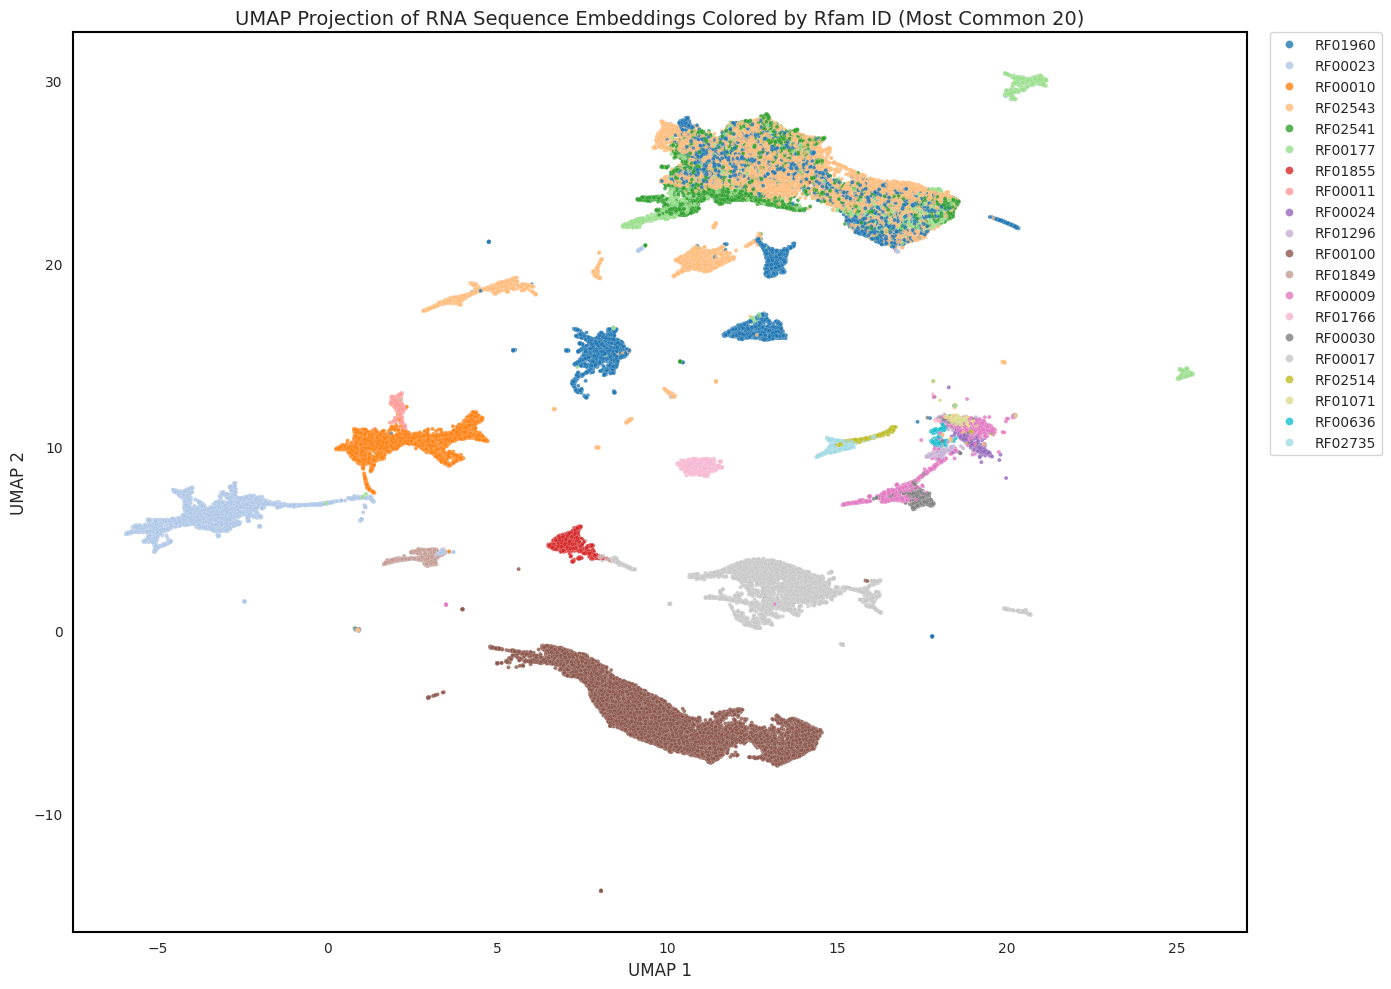

In [8]:
df_plot = pd.DataFrame(X_embedded, columns=['x', 'y']) #table for UMAP coordinates
df_plot['Rfam_ID'] = rfam_ids['rfam_id'].values #add rfam id labels
df_plot["length"] = fasta_df["length"].values #add length values
top_n = 20 #this variable for most common 20 families
top_ids = df_plot['Rfam_ID'].value_counts().nlargest(top_n).index #find their names
df_plot_filtered = df_plot[df_plot['Rfam_ID'].isin(top_ids)] #keep only the top 20
plt.figure(figsize=(14, 10)) #set figure size and canvas
sns.set_style("white") #set background
ax = sns.scatterplot(
    data=df_plot_filtered,
    x='x',
    y='y',
    hue='Rfam_ID',
    palette='tab20',   
    s=8,               
    alpha=0.8,         
    edgecolor='white', 
    linewidth=0.1      
) #plot aesthetics
plt.xlabel("UMAP 1", fontsize=12) 
plt.ylabel("UMAP 2", fontsize=12)
plt.title("UMAP Projection of RNA Sequence Embeddings Colored by Rfam ID (Most Common 20)", fontsize=14) #titles
plt.legend(
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0,
    title=None,
    frameon=True,     
    fontsize=10,
    markerscale=2     
) #legend aesthetics

#the for loop is from the GPT to make the black border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
    
#save and show without cutting!
plt.tight_layout()
plt.savefig("rfam_umap_plot.png", dpi=600, bbox_inches='tight')
plt.show()

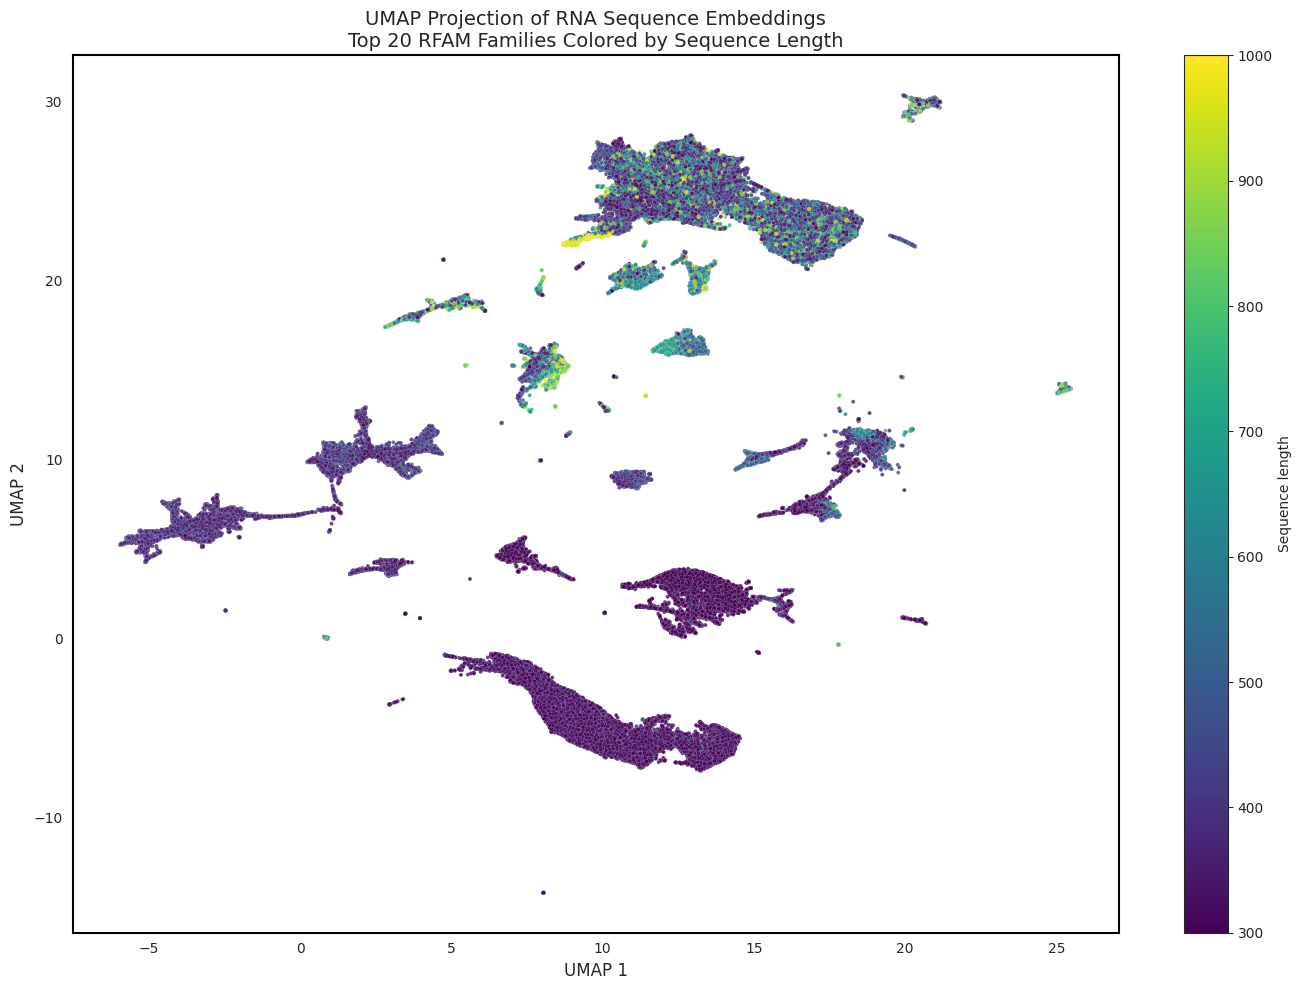

In [11]:
plt.figure(figsize=(14, 10)) #set figure size and canvas
sns.set_style("white") #set background
ax = sns.scatterplot(
    data=df_plot_filtered,
    x='x',
    y='y',
    hue='length',
    palette='viridis',   
    s=8,               
    alpha=0.8,         
    edgecolor='white', 
    linewidth=0.1,
    legend = False
) #plot aesthetics
# add colorbar manually (I used GPT for this)
norm = plt.Normalize(
    df_plot_filtered["length"].min(),
    df_plot_filtered["length"].max()
)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Sequence length")
plt.xlabel("UMAP 1", fontsize=12) 
plt.ylabel("UMAP 2", fontsize=12)
plt.title(
    "UMAP Projection of RNA Sequence Embeddings\n"
    "Top 20 RFAM Families Colored by Sequence Length",
    fontsize=14
) #title
#the for loop is from the GPT to make the black border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
    
#save and show without cutting!
plt.tight_layout()
plt.savefig("rfam_umap_plot_lengths.png", dpi=600, bbox_inches='tight')
plt.show()

In [6]:
alignment_score_matrix = pd.read_csv("alignment_matrix_3_perfam.csv", index_col=0) #pairwise alignment matrix aren shared with me

In [37]:
ids = alignment_score_matrix.index.tolist() #get indices which are in row and column names 
X = torch.stack([representations[i] for i in ids]) #stack and get the required indices
X_norm = F.normalize(X, p=2, dim=1) #Scales every vector so its length is exactly 1. (check the cos similarit formula we are forcing 
#denominator to be 1 so it is only the dot product
cosine_sim_matrix = X_norm @ X_norm.T  # Performs Matrix Multiplication (@) between the matrix and its Transpose (.T).
cosine_sim_df = pd.DataFrame(
    cosine_sim_matrix.cpu().numpy(),
    index=ids,
    columns=ids
) #format it as pd df

In [38]:
#get the pd to numpy array
align_mat = alignment_score_matrix.values 
cos_mat = cosine_sim_df.values
iu = np.triu_indices_from(align_mat, k=1) # get the upper
x = align_mat[iu]   # alignment scores
y = cos_mat[iu]     # cosine similarities

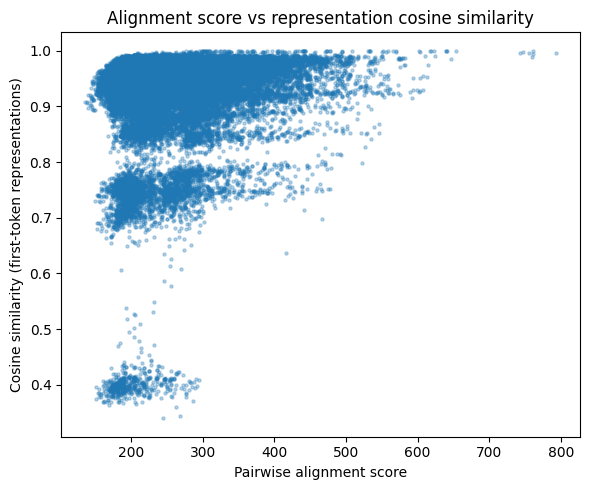

In [21]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)
plt.xlabel("Pairwise alignment score")
plt.ylabel("Cosine similarity (first-token representations)")
plt.title("Alignment score vs representation cosine similarity")
plt.tight_layout()
plt.savefig("scatter_plot_alignment_representation", dpi=600, bbox_inches='tight')
plt.show()

In [16]:
fasta_df

,sequence_id,description,sequence,length
580,URS0000003361_412133,Trichomonas vaginalis G3 Eukaryotic small subu...,TCTGGTGCTAATACATGCGATTGTTTCTCCAGATGTGAATTATGGA...,960
581,URS0000003361_5722,Trichomonas vaginalis Eukaryotic small subunit...,TCTGGTGCTAATACATGCGATTGTTTCTCCAGATGTGAATTATGGA...,960
1216,URS0000006194_243265,Photorhabdus luminescens subsp. laumondii TTO1...,GGGGCTGATTCTGGATTCGACGGGATTCGCGAAACCCAAGGTGCAT...,364
1377,URS0000007261_767434,Frateuria aurantia DSM 6220 transfer-messenger...,GGGGGTGTCCTGGCTTCGACGGGGGTAGTGAGATAGTTGAGTGCAT...,355
2537,URS000000A87C_446470,Stackebrandtia nassauensis DSM 44728 transfer-...,GGGGCCGATCGGTTTCGACTCCGTACGCTGATGTAAGGGAAGCGGG...,375
...,...,...,...,...
7817975,URS00034020F3_337451,Cinnamomum micranthum f. kanehirae Eukaryotic ...,ACTTTGATTACAGAAAGTGAATAATACAAAAACTAATAAATCTCAA...,349
7817985,URS00034020FB_43982,Ambrosiozyma monospora Eukaryotic large subuni...,GTCGTACTCATAACCGCAGCAGGTCTCCAAGGTTAACAGCCTCTAG...,320
7818083,URS000340214E_273540,Protea cynaroides Eukaryotic large subunit rib...,TGACCCCAGTTCAGGCGGGGCTACCCCATTGAGTTTAAGCATATCA...,909
7818108,URS0003402164_210632,Pseudambassis ranga (Indian glassy fish) Eukar...,CAGAATCAGCGGAGAAAGAAGACCCTGTTGAGCTTAACTCTAGTCT...,706


In [23]:
fasta_df = fasta_df.reset_index(drop=True)
lengths = fasta_df.loc[ids, "length"]
length_array = lengths.values
length_diff_matrix = np.abs(
    length_array[:, None] - length_array[None, :]
)
length_diff_df = pd.DataFrame(
    length_diff_matrix,
    index=ids,
    columns=ids
)
len_mat = length_diff_df.values 
iu = np.triu_indices_from(len_mat, k=1)  # get the upper
x = len_mat[iu]   # length differences

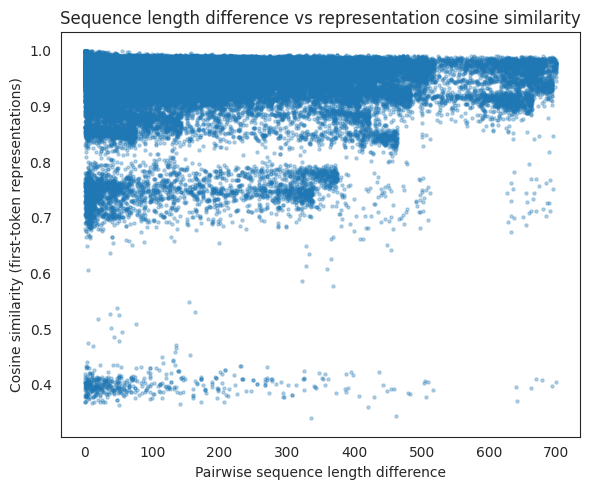

In [24]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)
plt.xlabel("Pairwise sequence length difference")
plt.ylabel("Cosine similarity (first-token representations)")
plt.title("Sequence length difference vs representation cosine similarity")
plt.tight_layout()
plt.savefig("scatter_plot_length_representation.png", dpi=600, bbox_inches="tight")
plt.show()

In [33]:
minimum_free_energy_table = pd.read_csv("mfes_3_perfam.csv", index_col=0) #minimum free energies provided by aren
minimum_free_energy_table = minimum_free_energy_table.reindex(ids) #reordering
minimum_free_energy_array = minimum_free_energy_table.values.flatten() #getting values
minimum_free_energy_matrix = np.abs(
    minimum_free_energy_array[:, None] - minimum_free_energy_array[None, :]
) #absolute differences of mfe
minimum_free_energy_df = pd.DataFrame(
    minimum_free_energy_matrix,
    index=ids,
    columns=ids
) #format it df
mfe_mat = minimum_free_energy_df.values #get values
iu = np.triu_indices_from(mfe_mat, k=1)  # get the upper
x = mfe_mat[iu]   # length differences

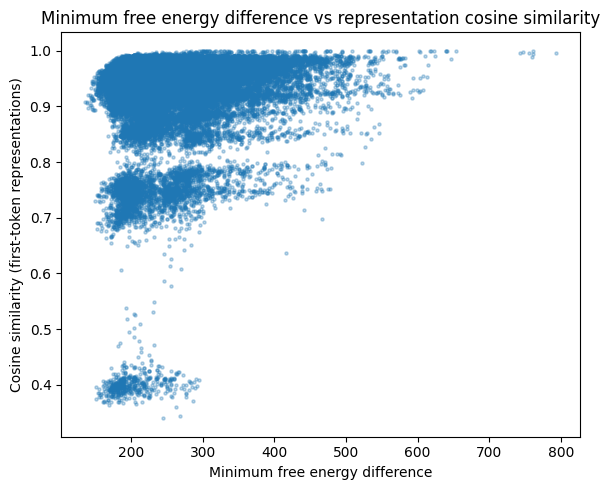

In [40]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)
plt.xlabel("Minimum free energy difference")
plt.ylabel("Cosine similarity (first-token representations)")
plt.title("Minimum free energy difference vs representation cosine similarity")
plt.tight_layout()
plt.savefig("scatter_plot_mfe_representation.png", dpi=600, bbox_inches="tight")
plt.show()